In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# load in the dataset
df_bills = pd.read_feather("117hrbills_encoded.feather")
df_bills

,bill_id,title,summary,sponsor_party,sponsor_state,sponsor_district,policy_area,subjects_count,introduced_date,passed_house
0,1,"[people, act, 2021]","[addresses, voter, access, election, integrity...",D,MD,3,Government Operations and Politics,113,0.000000,1
0,3,"[elijah, e, cummings, lower, drug, costs, act]","[establishes, several, programs, requirements,...",D,NJ,6,Health,47,0.148148,0
0,4,"[john, r, lewis, voting, rights, advancement, ...","[establishes, new, criteria, determining, stat...",D,AL,7,Government Operations and Politics,10,0.308642,1
0,5,"[equality, act]","[prohibits, discrimination, based, sex, sexual...",D,RI,1,"Civil Rights and Liberties, Minority Issues",15,0.061728,1
0,6,"[american, dream, promise, act, 2021]","[provides, certain, aliens, path, receive, per...",D,CA,40,Immigration,39,0.079561,1
...,...,...,...,...,...,...,...,...,...,...
0,9705,"[promoting, diverse, investment, advisers, act]","[requires, federal, reserve, board, set, goals...",D,OH,3,Finance and Financial Sector,1,1.000000,0
0,9706,"[ensuring, diverse, leadership, act, 2022]","[requires, appointing, president, federal, res...",D,OH,3,Finance and Financial Sector,1,1.000000,0
0,9707,"[mom, act]","[provides, block, grants, states, provide, chi...",R,TX,1,Families,1,1.000000,0
0,9708,"[fixing, administrations, unethical, corrupt, ...","[prohibits, specified, federal, officials, emp...",R,TX,1,Crime and Law Enforcement,1,1.000000,0


## One Hot Encoding Categorical Features

In [27]:
from sklearn.preprocessing import OneHotEncoder

In [30]:
categorical_features = df_bills[["sponsor_party", "sponsor_state", "sponsor_district", "policy_area"]]

# one hot encode categorical features
encoder = OneHotEncoder(sparse_output=False)
encoded_categorical_features = encoder.fit_transform(categorical_features)

In [34]:
encoded_categorical_features

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

## Tokenizing the Text

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input

In [8]:
summaries= [summary.tolist() for summary in df_bills["summary"]]
titles = [title.tolist() for title in df_bills["title"]]

# create the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(summaries + titles)

tokenized_summaries = tokenizer.texts_to_sequences(summaries)
tokenized_titles = tokenizer.texts_to_sequences(titles)

(array([7.880e+02, 2.441e+03, 1.777e+03, 1.296e+03, 8.670e+02, 6.810e+02,
        5.060e+02, 3.840e+02, 2.670e+02, 2.580e+02, 2.590e+02, 1.330e+02,
        2.500e+01, 6.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00]),
 array([  2. ,  15.8,  29.6,  43.4,  57.2,  71. ,  84.8,  98.6, 112.4,
        126.2, 140. , 153.8, 167.6, 181.4, 195.2, 209. , 222.8, 236.6,
        250.4, 264.2, 278. ]),
 <BarContainer object of 20 artists>)

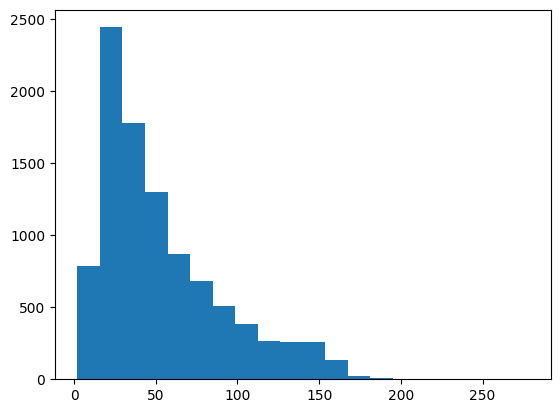

In [53]:
# plot histogram of summary word counts
plt.hist([len(i) for i in tokenized_summaries], bins=20)

(array([7.399e+03, 1.588e+03, 4.400e+02, 2.070e+02, 3.800e+01, 1.500e+01,
        7.000e+00, 3.000e+00, 0.000e+00, 1.000e+00]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. , 35.8, 41.6, 47.4, 53.2, 59. ]),
 <BarContainer object of 10 artists>)

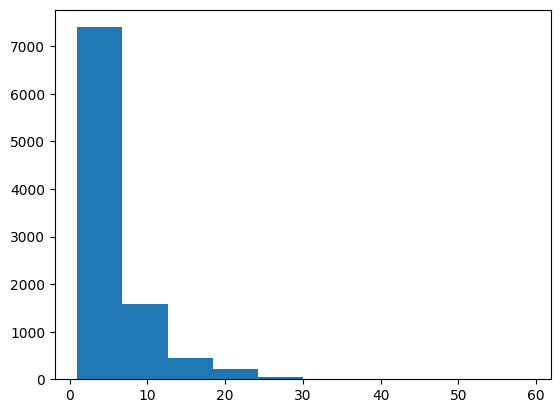

In [11]:
# plot histogram of title word counts
plt.hist([len(i) for i in tokenized_titles], bins=10)

In [12]:
# pad/truncate summaries to length 75 and titles to 10
max_summary_length = 75
max_title_length = 10

padded_summaries = pad_sequences(tokenized_summaries, 
                                 maxlen = max_summary_length, 
                                 padding = "post", 
                                 truncating = "post" , 
                                 value=0)

padded_titles = pad_sequences(tokenized_titles, 
                              maxlen = max_title_length, 
                              padding = "post", 
                              truncating = "post" , 
                              value=0)

In [38]:
# convert to numpy arrays
padded_summaries = np.array(padded_summaries)
padded_titles = np.array(padded_titles)

## Creating the Embedding Matrix
We're going to use pre-trained word vectors to create an embedding matrix for our text

In [14]:
from tqdm import tqdm

In [15]:
glove_file = "glove.42B.300d.txt"
embeddings_index = {}

with open(glove_file, "r", encoding="utf-8") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

1917495it [02:28, 12950.75it/s]


In [16]:
vocab_size = len(tokenizer.word_index) + 1  # add 1 because 0 is reserved for padding
embedding_dim = 300  # dimension of GloVe vectors

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Train Test Split and SMOTE

In [57]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [55]:
# get the labels as a numpy array
labels = df_bills["passed_house"].to_numpy()

In [56]:
concatenated_input = np.concatenate([padded_summaries, padded_titles, encoded_categorical_features], axis=1)

# split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(concatenated_input, labels, test_size=0.2, random_state=42, stratify=labels)

In [71]:
from imblearn.over_sampling import SMOTE

# separate the features back into their original components
X_train_summaries = X_train[:, :padded_summaries.shape[1]]
X_train_titles = X_train[:, padded_summaries.shape[1]:padded_summaries.shape[1]+padded_titles.shape[1]]
X_train_categorical = X_train[:, -encoded_categorical_features.shape[1]:]

# apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# separate the resampled features back into their original components
X_train_summaries_resampled = X_train_resampled[:, :padded_summaries.shape[1]]
X_train_titles_resampled = X_train_resampled[:, padded_summaries.shape[1]:padded_summaries.shape[1]+padded_titles.shape[1]]
X_train_categorical_resampled = X_train_resampled[:, -encoded_categorical_features.shape[1]:]

X_val_divided = [X_val[:, :padded_summaries.shape[1]], 
                 X_val[:, padded_summaries.shape[1]:padded_summaries.shape[1]+padded_titles.shape[1]], 
                 X_val[:, -encoded_categorical_features.shape[1]:]]

## Building the Model

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

In [74]:
model = Sequential()

# summary input and embedding layers
input_summaries = Input(shape=(max_summary_length,), name="input_summaries")
embedding_layer_summaries = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(input_summaries)
lstm_layer_summaries = LSTM(128)(embedding_layer_summaries)

# title input and embedding layers
input_titles = Input(shape=(max_title_length,), name="input_titles")
embedding_layer_titles = Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], trainable=False)(input_titles)
lstm_layer_titles = LSTM(128)(embedding_layer_titles)

# categorical features input layer
input_categorial = Input(shape=(encoded_categorical_features.shape[1],), name="categorical_input")

# combine lstm output with categorical features
combined_lstm = Concatenate()([lstm_layer_summaries, lstm_layer_titles])
combined_all = Concatenate()([combined_lstm, input_categorial])

# dense layers
x = Dense(64, activation='relu')(combined_all)
x = Dense(32, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)


model = Model(inputs=[input_summaries, input_titles, input_categorial], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[ tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])

# Print model summary
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_summaries     │ (None, 75)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_titles        │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 75, 300)   │  5,816,100 │ input_summaries[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_14        │ (None, 10, 300)   │  5,816,100 │ input_titles[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 128)       │    219,648 │ embedding_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 128)       │    219,648 │ embedding_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 256)       │          0 │ lstm_13[0][0],    │
│ (Concatenate)       │                   │            │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ categorical_input   │ (None, 145)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_13      │ (None, 401)       │          0 │ concatenate_12[0… │
│ (Concatenate)       │                   │            │ categorical_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │     25,728 │ concatenate_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      2,080 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │         33 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,099,337 (46.16 MB)

 Trainable params: 467,137 (1.78 MB)

 Non-trainable params: 11,632,200 (44.37 MB)

In [93]:
model.fit([X_train_summaries_resampled, X_train_titles_resampled, X_train_categorical_resampled], 
          y_train_resampled, 
          epochs=10, 
          batch_size=32, 
          validation_data=(X_val_divided, y_val))

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.0056 - precision: 0.9973 - recall: 0.9998 - val_loss: 0.7944 - val_precision: 0.2640 - val_recall: 0.2276
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0020 - precision: 0.9986 - recall: 0.9998 - val_loss: 0.8333 - val_precision: 0.2615 - val_recall: 0.2345
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - loss: 0.0030 - precision: 0.9983 - recall: 0.9993 - val_loss: 0.8463 - val_precision: 0.2603 - val_recall: 0.2621
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.0019 - precision: 0.9990 - recall: 0.9993 - val_loss: 0.8782 - val_precision: 0.2621 - val_recall: 0.2621
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0018 - precision: 0.9983 - recall: 0.9995 - val_loss: 0.8975 - val_precision: 0.2530 - val_recall: 0.2897
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - loss: 0.0014 - precision: 0.9991 - recall: 0.9989 - val_loss: 0.9582 - val_precision: 0.2593 -

## Analysis

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [95]:
y_pred = model.predict(X_val_divided)
y_pred_classes = (y_pred > 0.5).astype(int)

61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


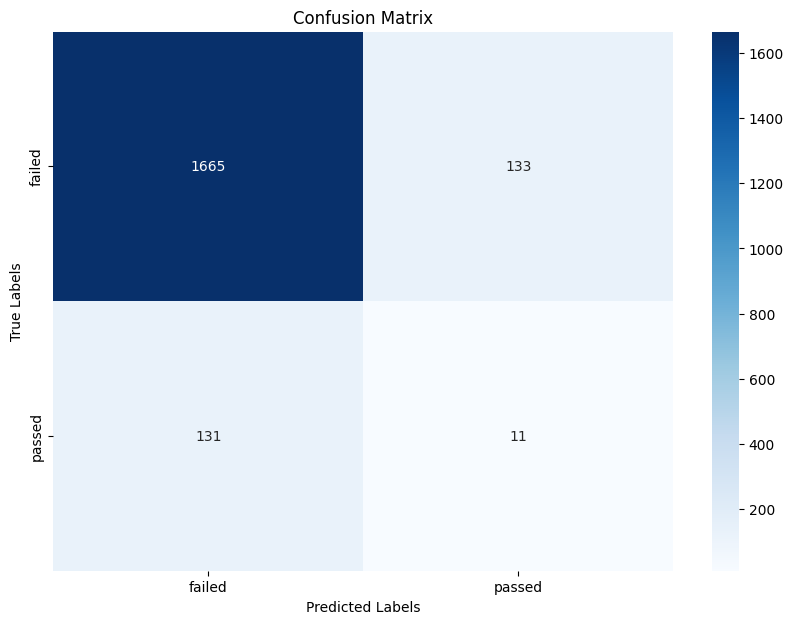

In [96]:
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["failed", "passed"],  # Adjust class labels as needed
            yticklabels=["failed", "passed"])  # Adjust class labels as needed
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()